In [1]:
import numpy as np
import torch
from torch import nn

# Теория

## Сверточные нейронные сети

### Операция свертки

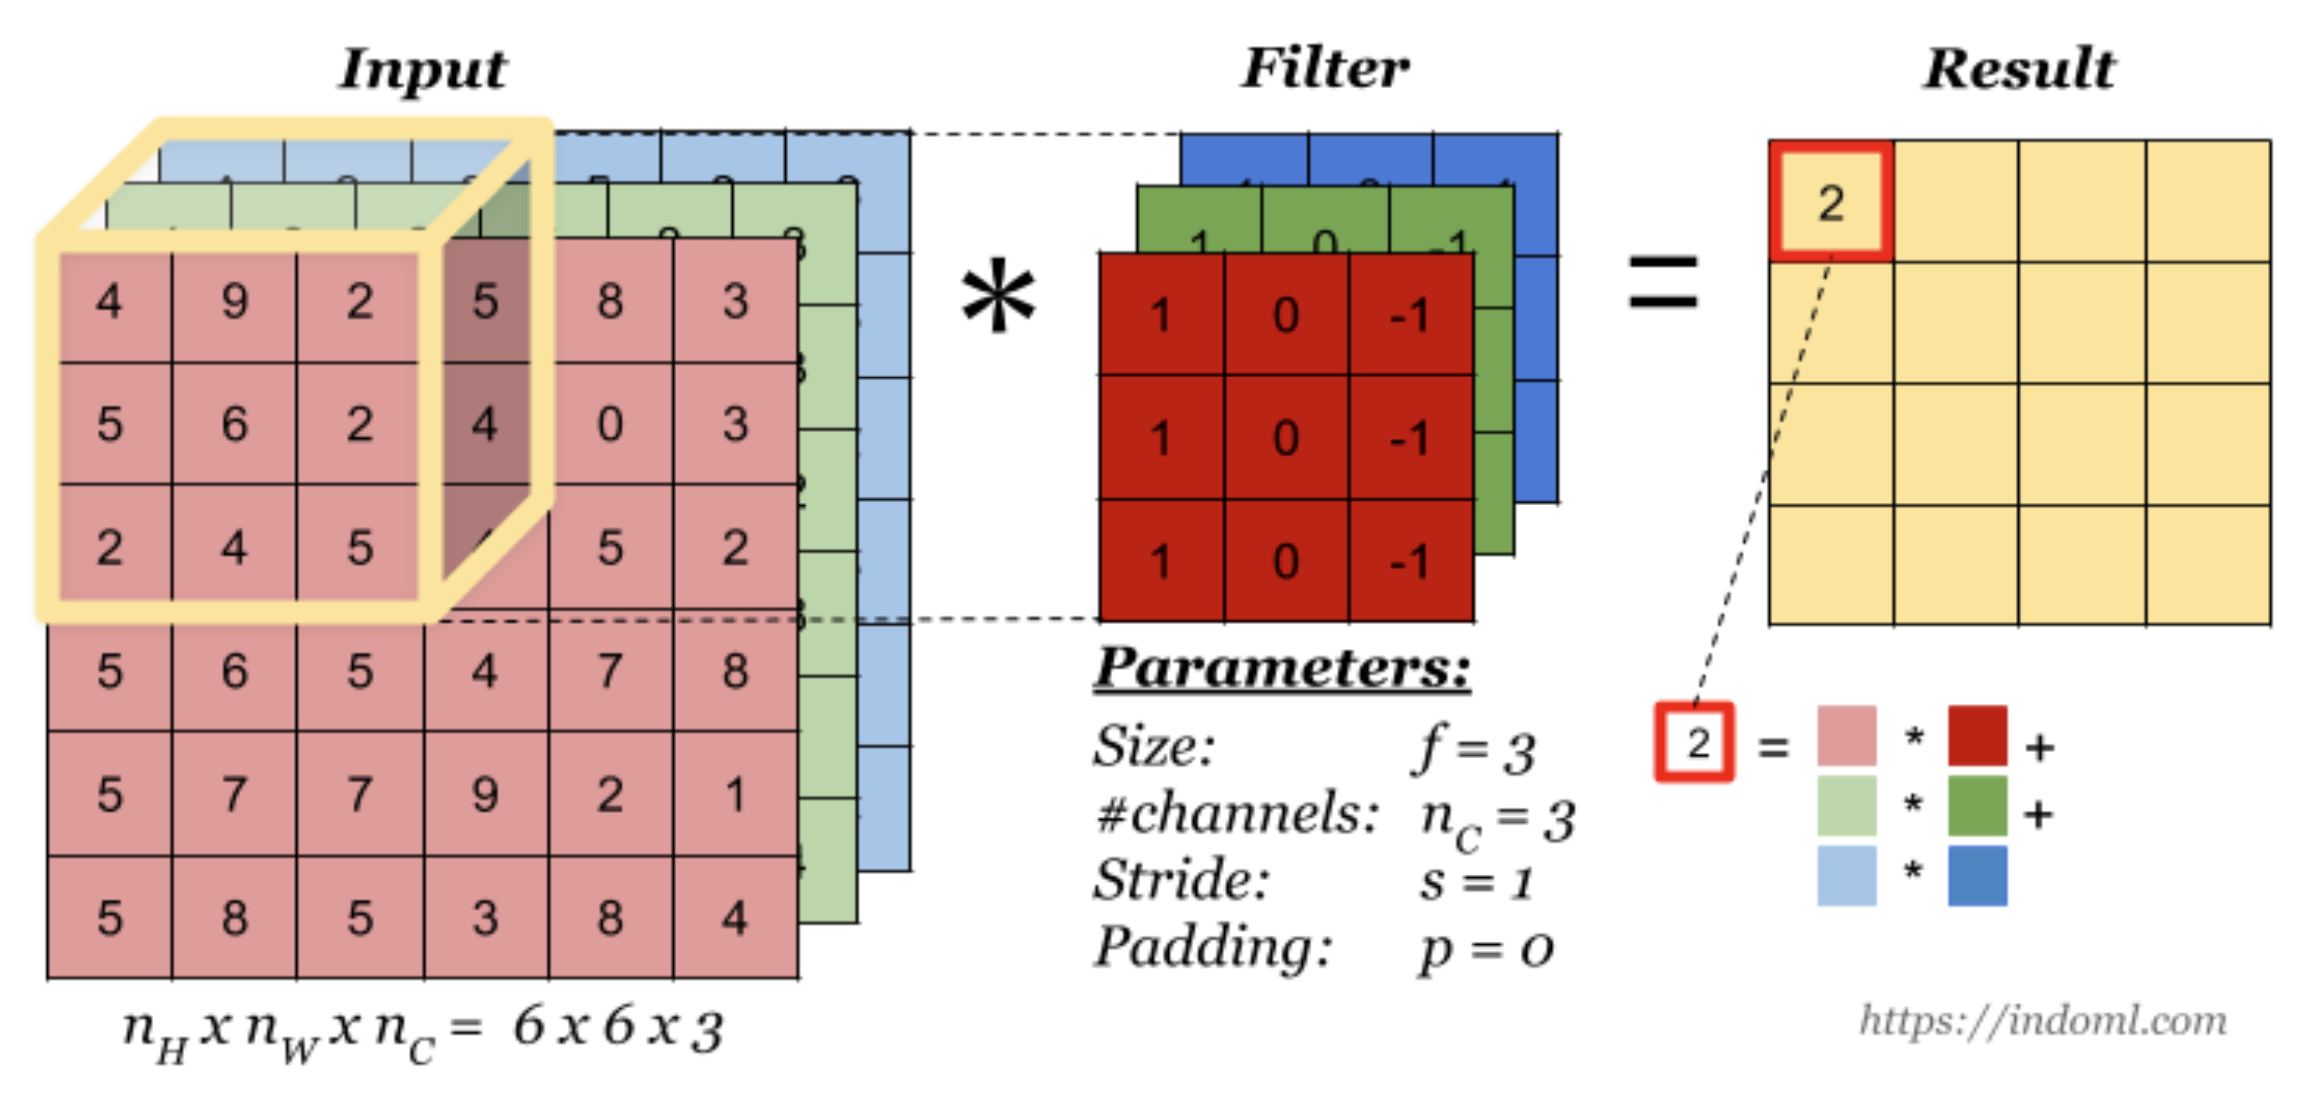

Простейшая имплементация, с двухмерным ядром (взято из https://towardsdatascience.com/how-are-convolutions-actually-performed-under-the-hood-226523ce7fbf)

In [ ]:
def custom_conv_2d_simplest_case(x, kernel, bias):
    kernel_shape = kernel.shape[0]
    
    # Assuming Padding = 0, stride = 1
    output_shape = x.shape[0] - kernel_shape + 1
    result = np.zeros((output_shape, output_shape))
    
    for row in range(x.shape[0] - 1):
        for col in range(x.shape[1] - 1):
            window = x[row: row + kernel_shape, col: col + kernel_shape]
            result[row, col] = (kernel * window).sum()
            
    return result + bias

Попробуем посмотреть на вариант с трехмерным ядром

Использование готового слоя nn.Conv2d

In [20]:
torch.random.manual_seed(1)

conv_layer = torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, bias=True)
kernel = conv_layer.weight
bias = conv_layer.bias if conv_layer.bias is not None else 0

X = torch.rand((1, 1, 3, 3), dtype=torch.float)
conv_layer(X)

tensor([[[[0.4085]],

         [[0.1071]]]], grad_fn=<ThnnConv2DBackward0>)

In [21]:
kernel.shape, bias.shape

(torch.Size([2, 1, 3, 3]), torch.Size([2]))

Простая реализация

In [22]:
def custom_conv_2d(
        x: torch.Tensor,  # [batch_size, channels, height, width]
        kernel: torch.Tensor,  # [kernel_channels, channels, kernel_size, kernel_size]
        bias: torch.Tensor,  # [1]
        ) -> torch.Tensor:  # [channels, height, width]
    
    # Assuming batch size 1
    x = x[0]  # [channels, height, width]
    # Assuming channels 1
    x = x[0]  # [height, width]
    kernel = kernel[:, 0]  # [kernel_channels, kernel_size, kernel_size]
    
    kernel_channels = kernel.shape[0]
    kernel_shape = kernel.shape[1]
    
    # Assuming Padding = 0, stride = 1
    output_shape = x.shape[1] - kernel_shape + 1
    result = torch.zeros((kernel_channels, output_shape, output_shape))
    
    for row in range(output_shape):
        for col in range(output_shape):
            window = x[row: row + kernel_shape, col: col + kernel_shape]
            
            result[:, row, col] = (kernel * window).sum((1, 2))
    
    return result + bias[:, None, None]

# Разница с оригинальной имплементацией
(conv_layer(X) - custom_conv_2d(X, kernel, bias)).abs().sum()

tensor(2.9802e-08, grad_fn=<SumBackward0>)

Для интересующихся - полная реализация на PyTorch (https://discuss.pytorch.org/t/how-was-conv2d-implemented-in-pytorch/35223)  
(понимание torch.nn.functional.unfold: https://stackoverflow.com/a/75186655)

In [26]:
def custom_conv_2d_full(x, kernel, bias):
    result = torch.nn.functional.unfold(x, 3)

    kernel_to_multiply = kernel.view(kernel.shape[0], -1).t()

    result = (result.transpose(1, 2) @ kernel_to_multiply).transpose(1, 2)
    return result.view(1, 2, 1, 1) + bias[:, None, None]

(conv_layer(X) - custom_conv_2d_full(X, kernel, bias)).abs().sum()

tensor(0., grad_fn=<SumBackward0>)

### Stride (шаг)
На сколько мы перемещаемся при каждой свертке

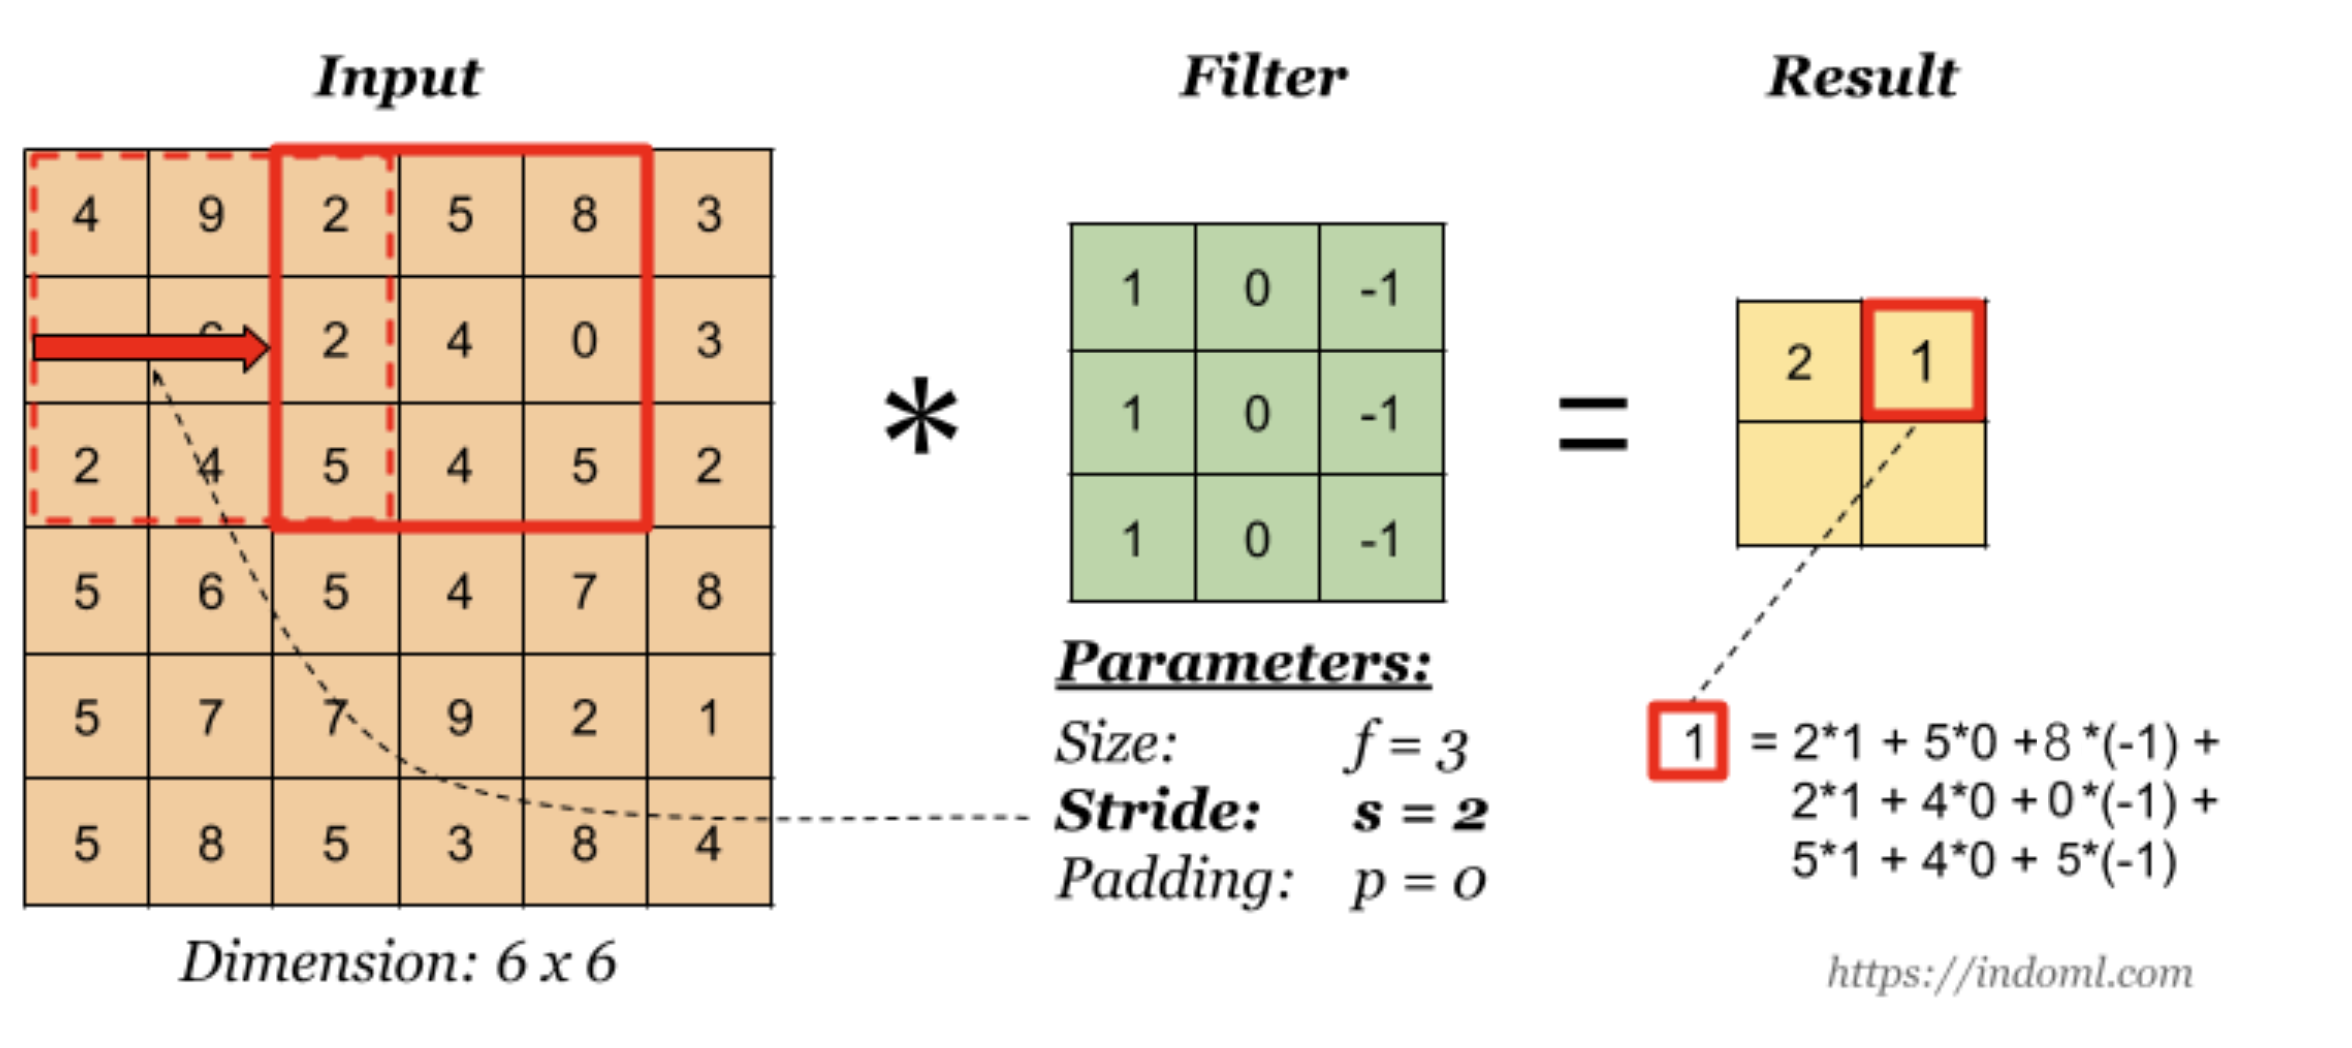

Как свертка двигается при kernel=3, stride=1, входное фото 5x5:

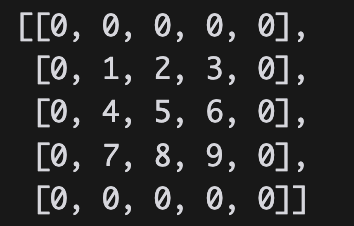

Если сделаем stride=2:

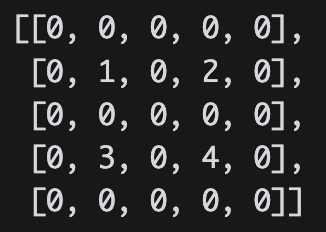

Проверим:

In [31]:
X = torch.rand((1, 1, 5, 5), dtype=torch.float)

conv_layer_stride_1 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
conv_layer_stride_1(X).shape

torch.Size([1, 1, 3, 3])

In [32]:
conv_layer_stride_2 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2)
conv_layer_stride_2(X).shape

torch.Size([1, 1, 2, 2])

### Padding
Просто добавляем к входной матрице на границе пустых пикселей (при padding=1 входная и выходная матрицы имеют один размер)

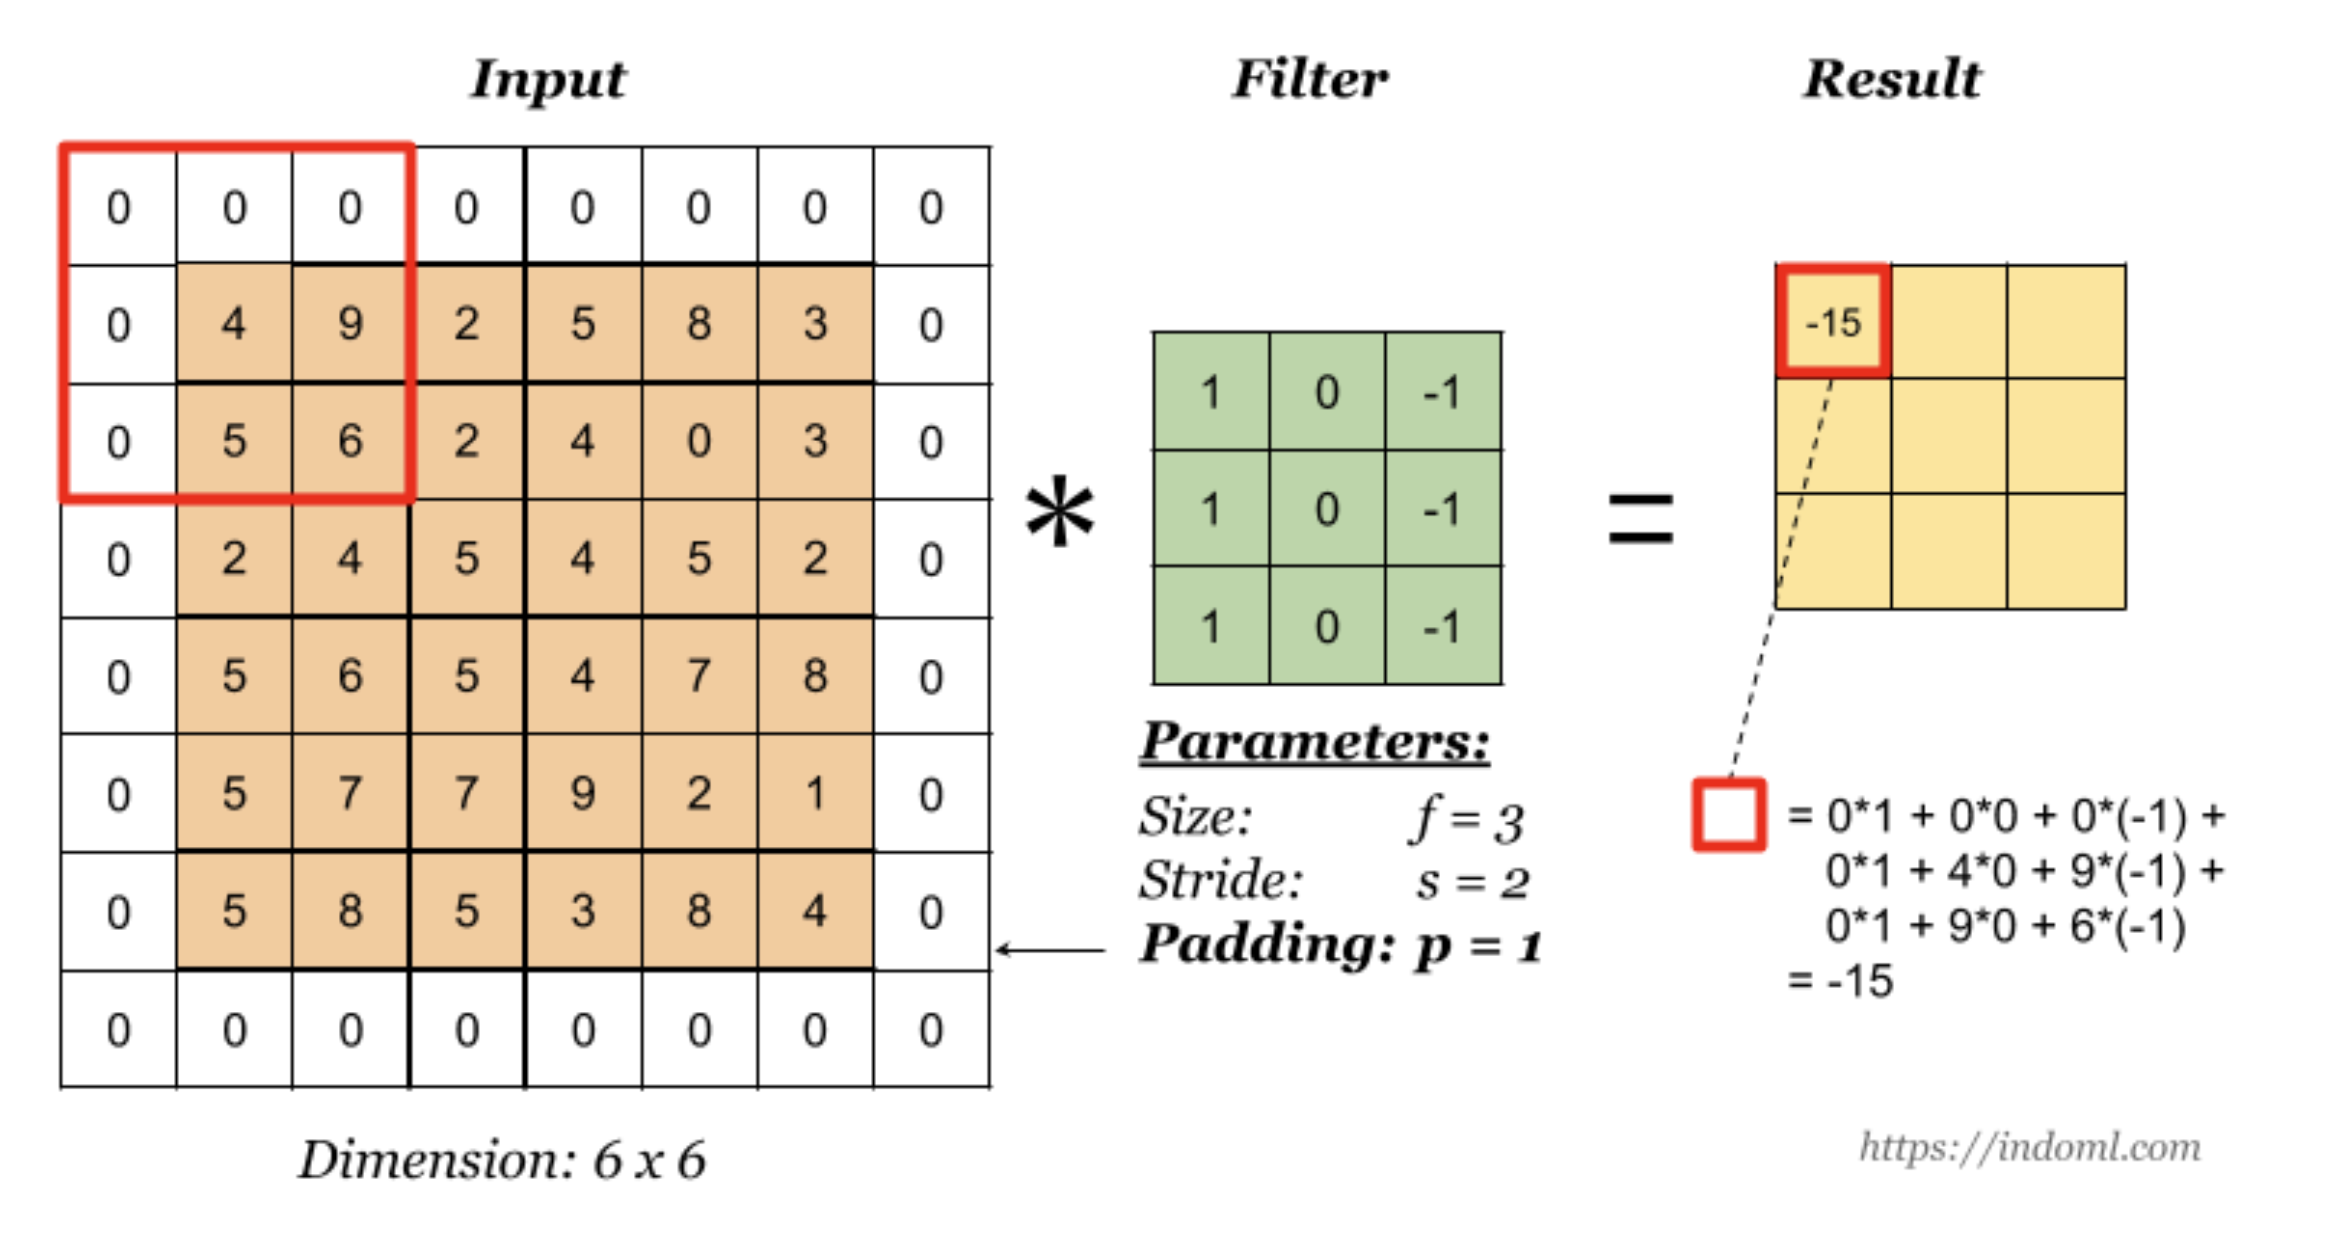

In [34]:
conv_layer_padding = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
X.shape, conv_layer_padding(X).shape

(torch.Size([1, 1, 5, 5]), torch.Size([1, 1, 5, 5]))

Набор хороших визуализаций всего описанного выше: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

### Receptive field

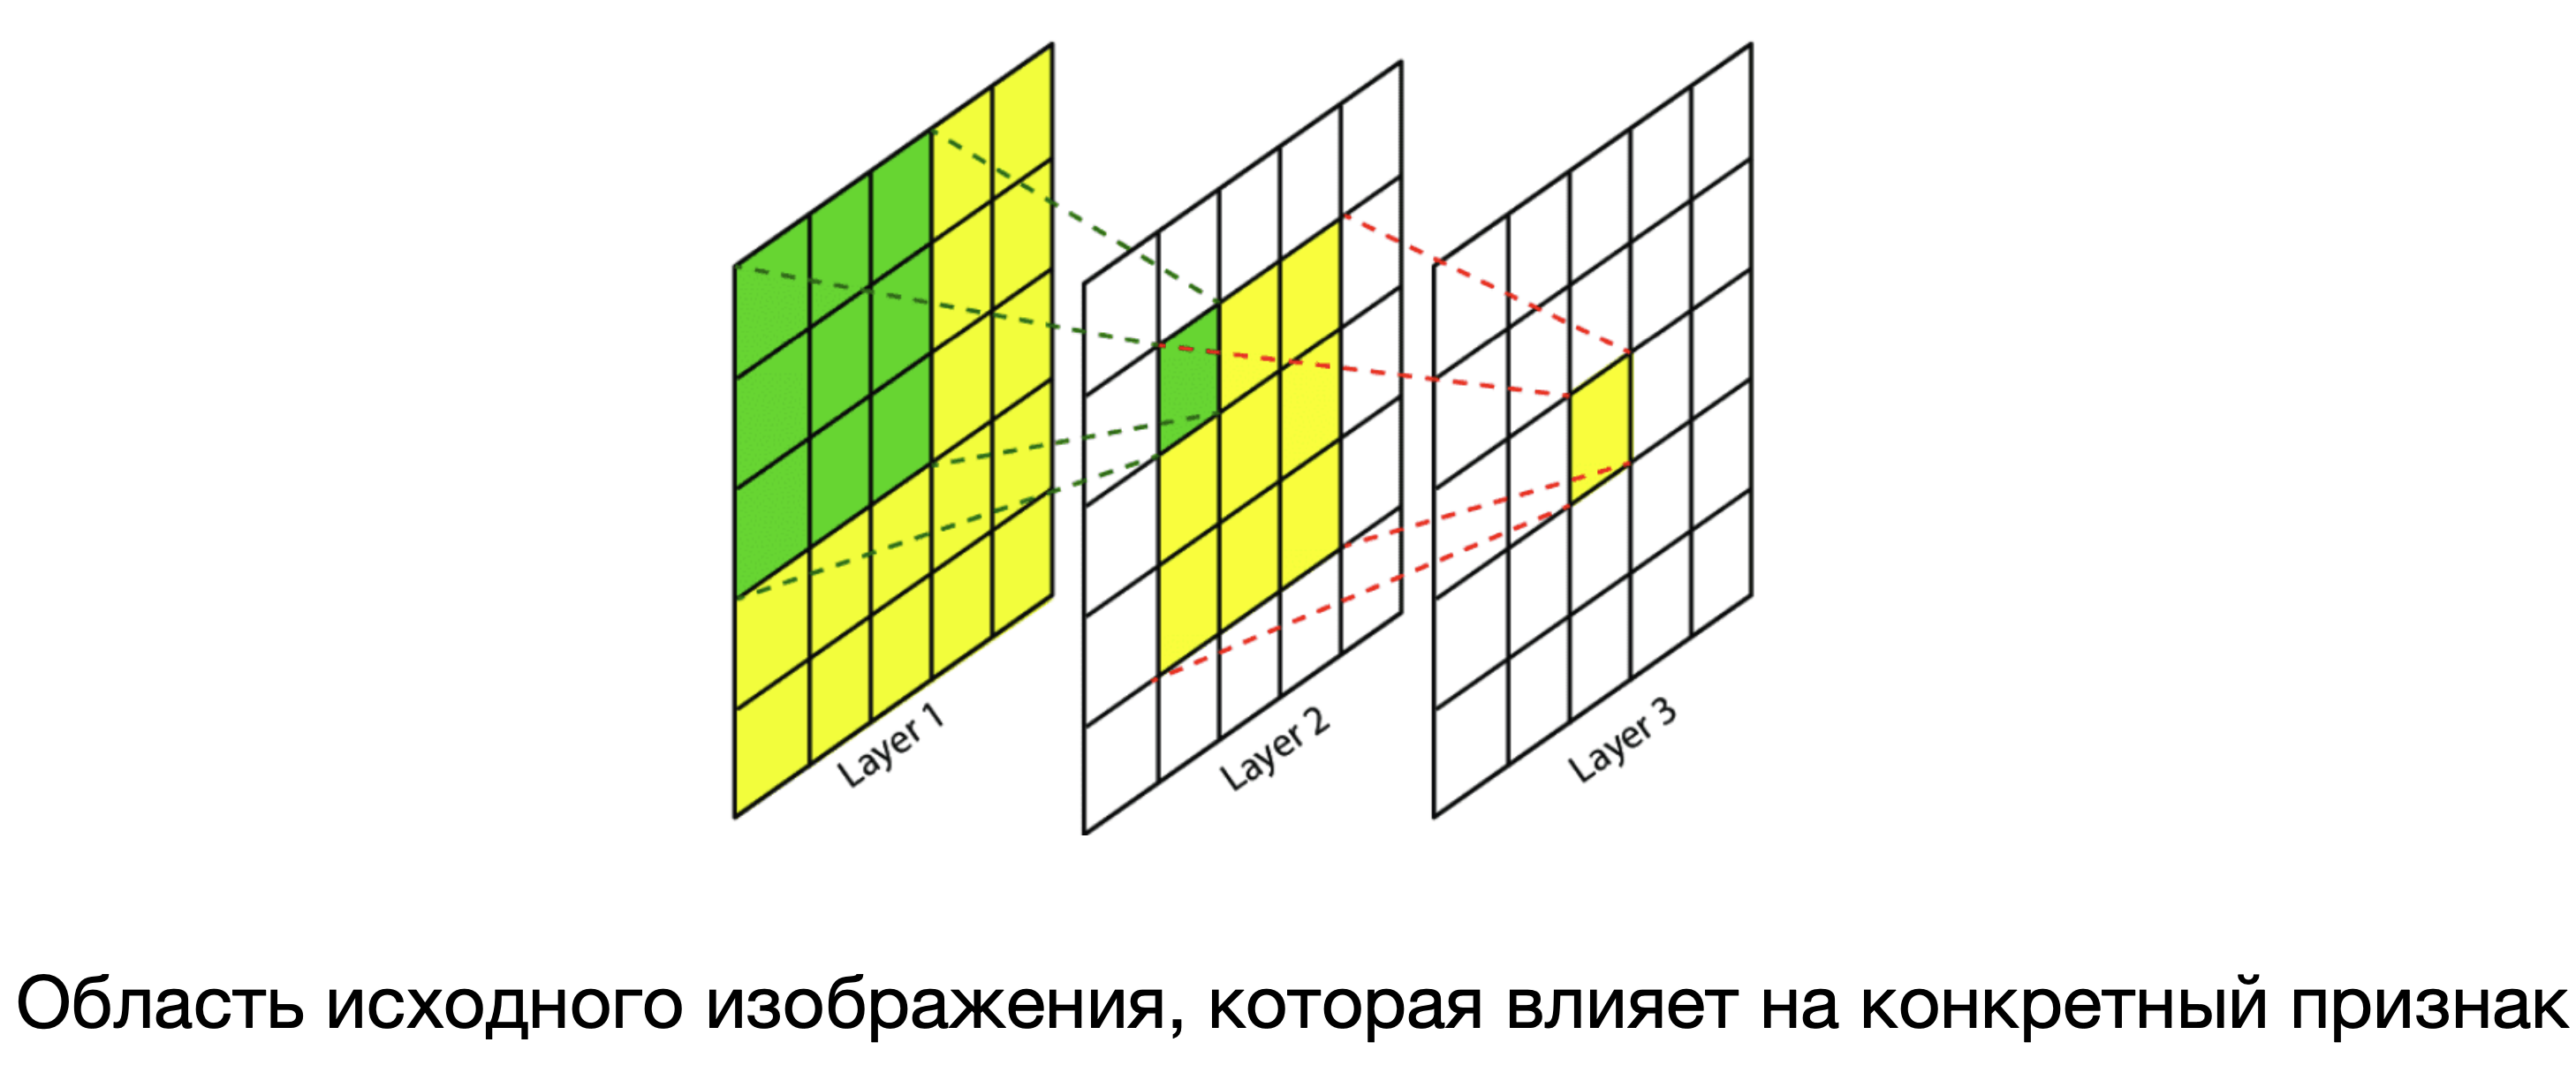

## Transfer learning

Для облегчения обучения нейронных сетей стандартной практикой является использование так называемого transfer learning: берется уже обученная нейронная сеть на какой-либо задаче (обычно это задача в той же области, что и задача, которую вы хотите решить), и последние слои переобучаются на новую задачу.

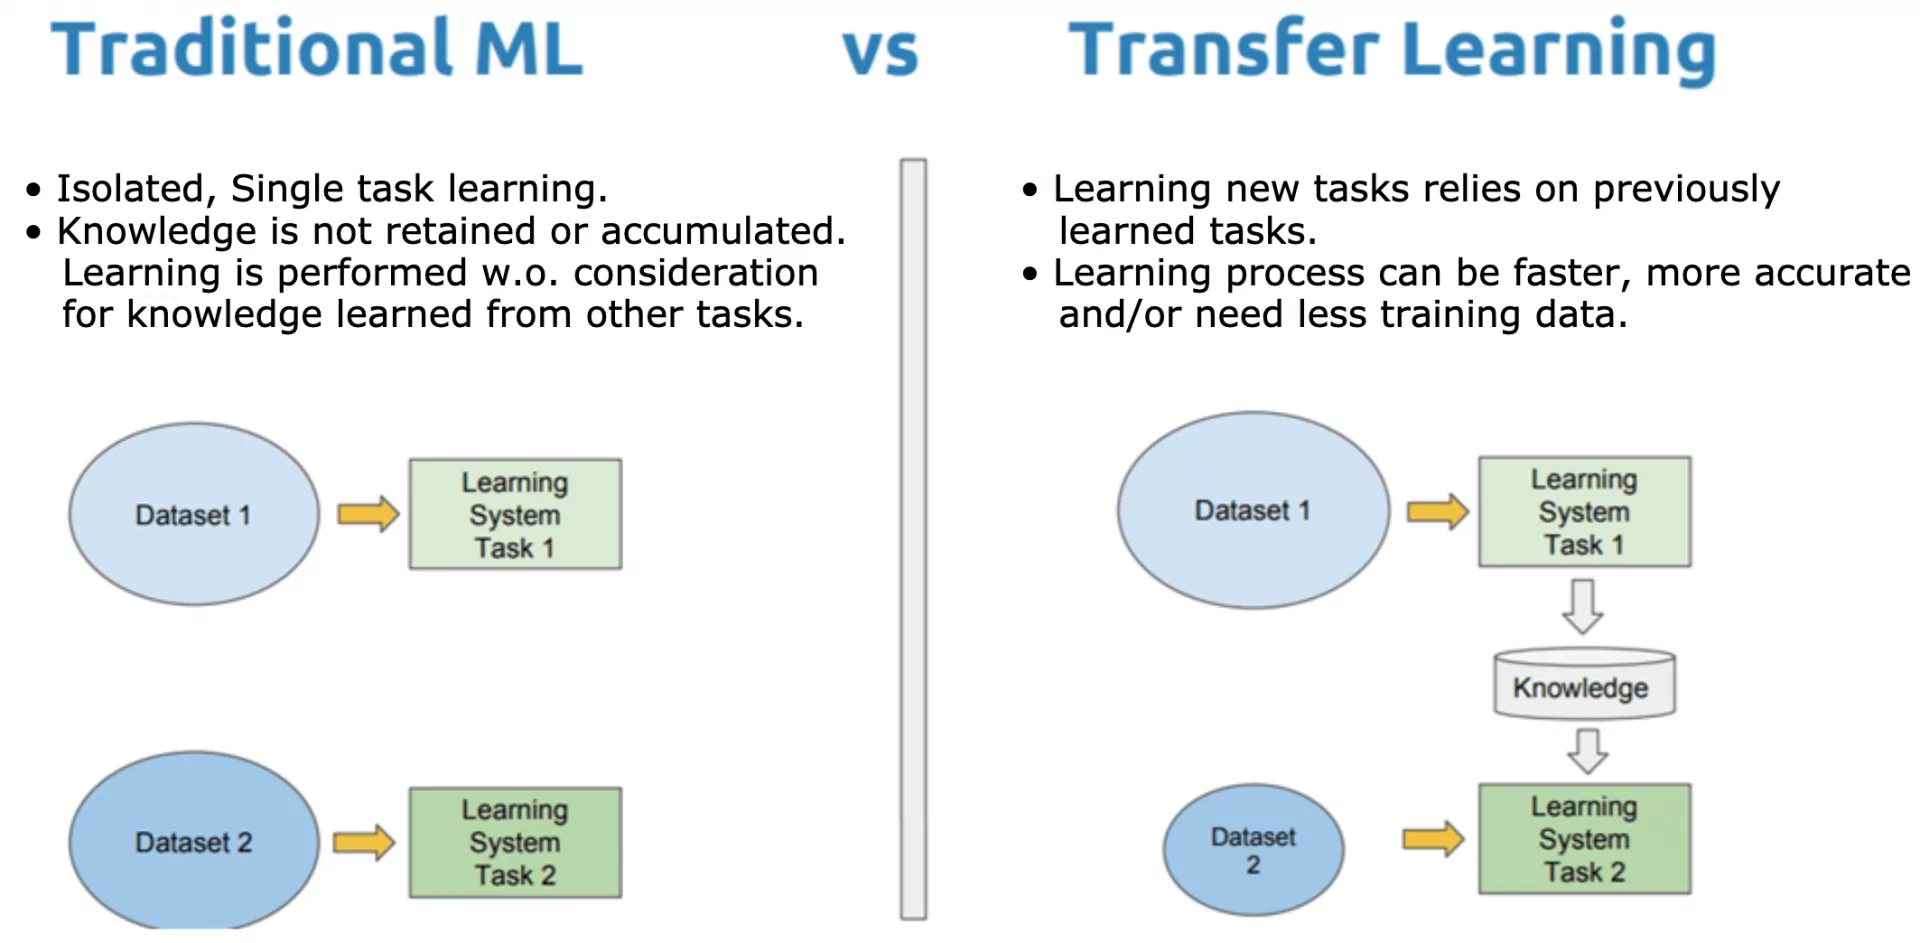

При дообучении есть проблема с первыми итерациями бэкпропа градиентов: так как сначала ошибка модели большая, то и градиенты будут большими, что может "сбросить" предобученные веса, если они не заморожены. 

Поэтому существует стандартная практика при дообучении: использование вармапа (warmup) в LRScheduler - на первых итерациях learning rate будет очень маленьким чтобы не сбить модель. 

# Задачи

### 1 Решить задачу классификации в датасете Fashion MNIST, используя сверточные слои. 
1. Предложить архитектуру модели для решения задачи
2. Посчитать количество параметров модели.
3. Обучить модель.
4. Вывести график функции потерь по эпохам. 
5. Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy и f1 на тестовом множестве (обе метрики >= 0.7).

* Сохранить модель

### Датасет

In [1]:
from pathlib import Path
import sys

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm.notebook import tqdm

# Автоматически перезагружает код из модулей, если он был изменен
# очень удобно при разработке модулей и параллельном использовании юпитер ноутбуков
%load_ext autoreload
%autoreload 2

# Добавим папку byte-deep-learning в PATH 
# чтобы можно было импортировать библиотеку src, которая находится в этой папке
repo_dir = Path().resolve().parent
sys.path.append(str(repo_dir))

In [2]:
data_path = './data/fmnist'
# данные в виде картинок 28x28
# ToTensor превратит в тензоры 1x28x28
train_dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

In [3]:
# Валидационный датасет
val_ratio = 0.2

train_dataset, val_dataset = random_split(
    dataset=train_dataset, 
    lengths=[1-val_ratio, val_ratio],
)

### 1.1 Модель

In [4]:
class CustomCNN(nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        # Тело нейронки, выдает логиты
        self.inner = nn.Sequential(
            # <YOUR CODE>
        )

    def forward(self, x):
        return self.inner(x)

### 1.2 Количество параметров модели

In [ ]:
# <YOUR CODE>

### 1.3 Обучение модели

In [5]:
from src.engine import Trainer

num_classes = len(train_dataset.dataset.classes)
model = CustomCNN(num_classes)
# <YOUR CODE>
optimizer = ...
criterion = ...
batch_size = ...

trainer = Trainer(
    model, 
    optimizer=optimizer, 
    criterion=criterion,
    train_dataset=train_dataset, 
    val_dataset=val_dataset, 
    batch_size=batch_size,
)

trainer.train(...)

### 1.4 Вывод графика ошибки

Если работает tensorboard, можно просто его посмотреть

В VS Code при наличии расширения tensorboard можно нажать ctrl/cmd + shift + P для запуска, либо Launch TensorBoard Session в ячейке ниже, если отображается

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./runs

### 1.5 Тест

In [ ]:
from src.engine import evaluate_loader

test_loader = DataLoader(test_dataset, shuffle=False, pin_memory=True, batch_size=1)
evaluate_loader(...)

### 2 Задание 1 с Transfer Learning
1. В качестве базовой архитектуры используйте предобученную модель resnet18: замените последний линейный слой на новый с количеством классов FashionMNIST, заморозьте веса всех слоев кроме последнего.  
2. Посчитать количество замороженных и незамороженных параметров модели.
3. Обучить модель с двумя LR Scheduler: WarmUp и MultiStepLR 

    *Для инференса на предобученной модели нужно будет модифицировать transform в датасетах, чтобы входной тензор имел 3 канала*.
    
    *Код WarmupScheduler взят из https://github.com/hysts/pytorch_warmup-scheduler, для использования нескольких планировщиков можно использовать torch.optim.lr_scheduler.ChainedScheduler*
    
    *Обратите внимание на разницу между эпохами и шагами (steps), по которым в нашем Trainer работают планировщики*
4. Вывести график функции потерь по эпохам. 
5. Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy и f1 на тестовом множестве.

6. Сравнить модели из первого и второй задачи. В чем может быть причина их разницы, как можно исправить проблемы, которые могли появиться?

### 2.1 Загрузка модели

In [13]:
# <YOUR CODE>

### 2.2 Количество параметров модели

In [ ]:
# <YOUR CODE>

### 2.3 Обучение модели

In [9]:
rgb_transform = ...

train_dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=rgb_transform)
test_dataset = datasets.FashionMNIST(data_path, train=False, download=True, transform=rgb_transform)
# Валидационный датасет
valid_ratio = 0.2

train_dataset, valid_dataset = random_split(
    dataset=train_dataset, 
    lengths=[1-valid_ratio, valid_ratio],
)

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR, ChainedScheduler
from src.optim import WarmupScheduler


num_classes = len(train_dataset.dataset.classes)
optimizer = ...
criterion = ...
scheduler = ...
batch_size = ...

trainer = Trainer(
    model, 
    optimizer=optimizer, 
    criterion=criterion,
    train_dataset=train_dataset, 
    val_dataset=valid_dataset, 
    scheduler=scheduler,
    batch_size=batch_size,
)

trainer.train(...)

### 2.5 Тест

In [ ]:
from src.engine import evaluate_loader

test_loader = DataLoader(test_dataset, shuffle=False, pin_memory=True, batch_size=1)
evaluate_loader(...)

In [ ]:
# <YOUR CODE>

### 2.6 Размышления

In [ ]:
# <YOUR CODE>